In [271]:
!{sys.executable} -m pip install pandas 

  Using cached pandas-1.5.0-cp310-cp310-win_amd64.whl (10.4 MB)
  Using cached pytz-2022.4-py2.py3-none-any.whl (500 kB)


In [7]:
#Imports 
import pip
import glob, os
from sklearn import svm 
import scipy.io
import numpy as np
from HelperFunctions_ import write_dataset_to_file, split_dataset_paths
import sys 
from spectral import *

import tables as tab
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.semi_supervised import SelfTrainingClassifier
import pandas as pd
from sklearn import datasets
import copy


In [3]:
iris = datasets.load_iris()
X = iris.data 
y = iris.target

In [4]:
#Finding path names 
Mjosa_data = split_dataset_paths("../Datasets/2022_07_11_Mjosa/2022_07_11_Mjosa/", ["he5", "csv", "jpg"])
Andebu_data = split_dataset_paths("../Datasets/2021_07_21_Andebu/2021_07_21_Andebu/", ["he5", "csv", "jpg"])
Telemark_data = split_dataset_paths("../Datasets/2020_06_23_Telemarkskanalen/2020_06_23_Telemarkskanalen/", ["he5", "csv", "jpg"])


In [115]:
#Amount of dataset should be handled
N_datasets = 3

#Open files 
open_files_array = []
for i in range(N_datasets):
    file = tab.open_file(Mjosa_data["he5"][i])
    open_files_array.append(file.get_node("/HDFEOS/SWATHS/PRS_L1_HCO/")['Data Fields']['VNIR_Cube'][:,5:,:])

#Load the labels 
load_labels_array = []
for i in range(N_datasets):
    file = Mjosa_data["csv"][i]
    load_labels_array.append(np.loadtxt(file, dtype=np.ubyte))

In [116]:
data = open_files_array[0]
labels = load_labels_array[0]

data_test = open_files_array[2]
labels_test = load_labels_array[2]

def OneClass(labels, class_value): 
    new_labels = copy.deepcopy(labels)
    for i in range(len(labels)): 
        for j in range(len(labels[0])): 
            if(labels[i][j] != class_value): 
                labels[i][j] = 0
    return new_labels 

labels_0 = OneClass(labels = labels, class_value = 2)
print(labels_0)



[[2 2 3 ... 5 5 5]
 [1 1 1 ... 1 1 1]
 [2 1 1 ... 1 1 1]
 ...
 [2 2 5 ... 0 0 0]
 [3 2 5 ... 0 0 0]
 [1 1 5 ... 0 0 0]]


In [117]:
def preprocesing_data(data,labels): 
    # prepare data
    X = data.transpose(0,2,1).reshape((-1,61))
    y = labels.flatten()

    X = preprocessing.scale(X, axis=0)                    # Normalization
    #X = preprocessing.normalize(X, axis=0) 
    return X,y 
print(labels_0)
X,y = preprocesing_data(data,labels_0)
X_test, y_test = preprocesing_data(data_test, labels_test)

[[2 2 3 ... 5 5 5]
 [1 1 1 ... 1 1 1]
 [2 1 1 ... 1 1 1]
 ...
 [2 2 5 ... 0 0 0]
 [3 2 5 ... 0 0 0]
 [1 1 5 ... 0 0 0]]


c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [118]:

"""
# prepare data
X = data.transpose(0,2,1).reshape((-1,61))
y = labels.flatten()

X = preprocessing.scale(X, axis=0)                    # Normalization
#X = preprocessing.normalize(X, axis=0)             # Standardization
print(X.shape, y.shape)
"""
"""
X_array, y_array = [],[]

X,y = preprocesing_data(data=data, labels=labels)
    
X_array.append(X)
y_array.append(y)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.999, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

"""
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.999, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)




(1000, 61) (999000, 61) (1000,) (999000,)


In [119]:
#class_weights = {0: 1, 1: 1, 2: 1, 3: 1 , 4:1, 5:1}
class_weights = {0:1, 1:1}

In [120]:
#Linear SVM 
# Generate SVM from training data
# 1) Spruce, 2) Pine , 3) Decidous (leaf), 4) Water, 5) Clouds, and 0) other

#svma = LinearSVC(max_iter=1e5, tol=1e-5, class_weight=class_weights)
svma = SVC(
    C = 10,
    kernel = "linear", 
    degree = 3,
    gamma = "scale", 
    coef0 = 0.0, 
    probability = True, 
    tol = 1e-3, 
    cache_size = 400,
    class_weight = class_weights, 
    verbose = True, 
    max_iter = 1e3, 
    decision_function_shape = "ovr",
    break_ties = True, 
    random_state = 1
)

svma.fit(X_train, y_train)
print("support vectors:", len(svma.support_))
print(svma.classes_)

[LibSVM]support vectors: 542
[0 1 2 3 4 5]


c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [121]:
#Decision Tree 
#Make the different models. 



In [122]:
# calculate overall accuracy on Training data
(svma.predict(X_train)==y_train).sum()/len(y_train)

0.712

In [123]:
# Accuracy on test data
(svma.predict(X_test)==y_test).sum()/len(y_test)

0.6892612612612613

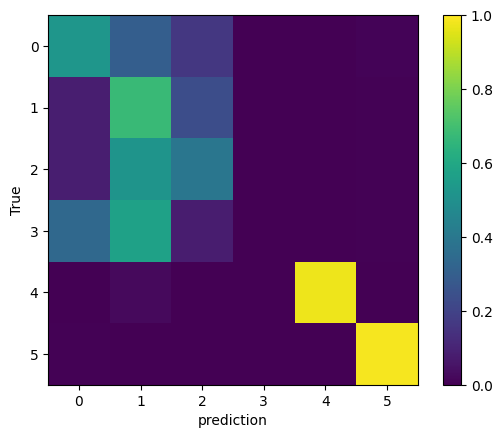

In [124]:
Xout = svma.predict(X)

plt.imshow(Xout.reshape((1000,1000)))

cm = confusion_matrix(labels_0.flatten(), Xout, normalize='true')

plt.imshow(cm, vmax=1, vmin=0)
plt.ylabel('True')
plt.xlabel('prediction')
plt.colorbar()

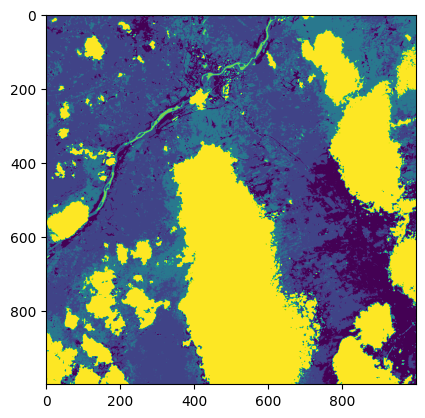

In [125]:
plt.imshow(Xout.reshape((1000,1000)))

In [126]:
print(svma.score(X_tester, y_tester))

NameError: name 'X_tester' is not defined